In [7]:
%pip install numpy pandas matplotlib seaborn scikit-learn xgboost streamlit gradio
import numpy as np, pandas as pd 
import matplotlib as plt
import seaborn as sns
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from math import sqrt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
import streamlit as st
from sklearn.preprocessing import  LabelEncoder
from sklearn.linear_model import Lasso, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

trainingData = pd.read_csv('train.csv')
testingData = pd.read_csv('test.csv')

trainingData.shape
trainingData.head()

df = trainingData 




[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


KeyboardInterrupt: 

In [8]:
trainingData.describe()


,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [ ]:
print(trainingData.isna().sum().sort_values())

id                          0
title                       0
status                      0
release_date                0
popularity                  0
original_title              0
revenue                     0
imdb_id                     0
budget                      0
original_language           0
poster_path                 1
runtime                     2
genres                      7
overview                    8
cast                       13
crew                       16
spoken_languages           20
production_countries       55
production_companies      156
Keywords                  276
tagline                   597
homepage                 2054
belongs_to_collection    2396
dtype: int64


In [ ]:
trainingData.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

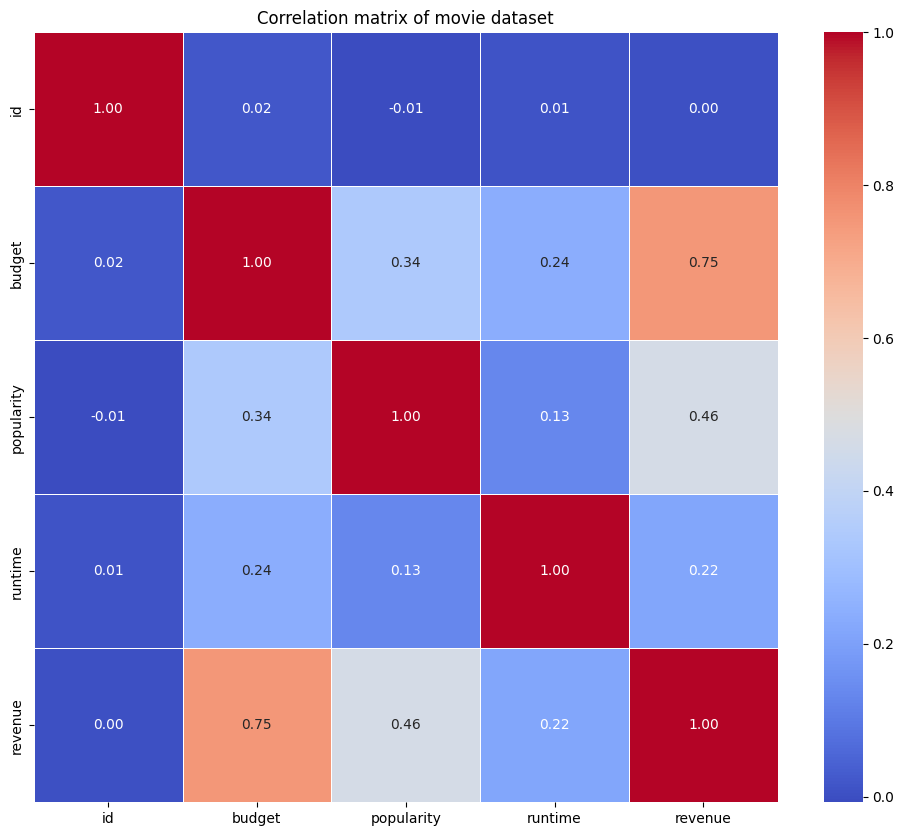

In [ ]:
import matplotlib.pyplot as plt

numeric_data = trainingData.select_dtypes(include=[np.number])
# Calculate the correlation matrix
corr_matrix = numeric_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
# 'annot=True' to write the data value in each cell
# 'cmap' to choose the color palette
# 'fmt' to format the annotation if 'annot' is True
# 'linewidths' to set the width of the lines that will divide each cell
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

# Add a title to the heatmapx
plt.title('Correlation matrix of movie dataset')

# Show the plot
plt.show()


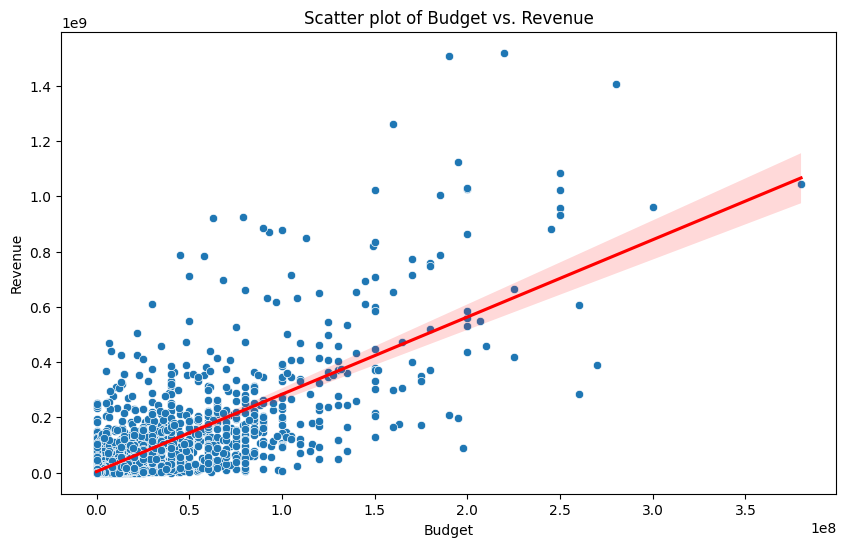

In [ ]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(x='budget', y='revenue', data=trainingData)

# Adding a trend line to see the correlation more clearly
sns.regplot(x='budget', y='revenue', data=trainingData, scatter=False, color='red')

plt.title('Scatter plot of Budget vs. Revenue')  # Set the title of the plot
plt.xlabel('Budget')  # Set the x-axis label
plt.ylabel('Revenue')  # Set the y-axis label
plt.show()  # Display the plot


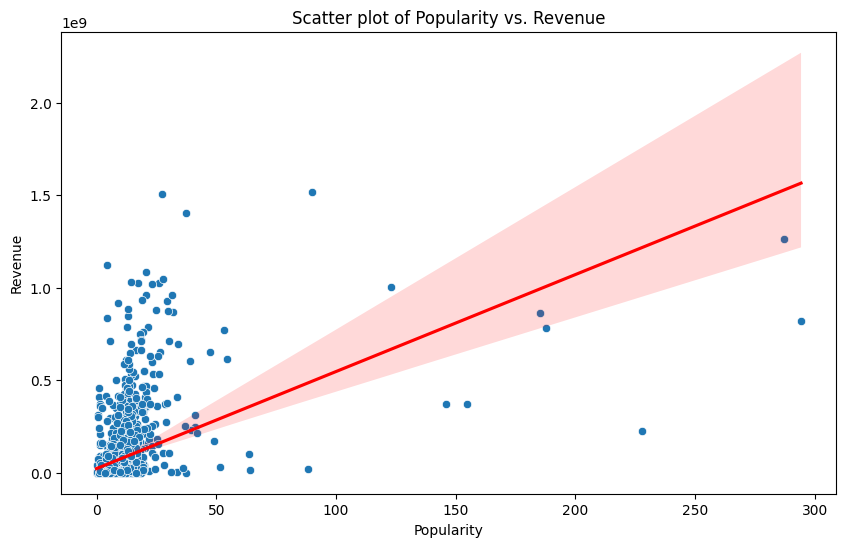

In [ ]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(x='popularity', y='revenue', data=trainingData)

# Adding a trend line to see the correlation more clearly
sns.regplot(x='popularity', y='revenue', data=trainingData, scatter=False, color='red')

plt.title('Scatter plot of Popularity vs. Revenue')  # Set the title of the plot
plt.xlabel('Popularity')  # Set the x-axis label
plt.ylabel('Revenue')  # Set the y-axis label
plt.show()  # Display the plot

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Remove 'id' column
trainingData = trainingData.drop('id', axis=1)

# Replace zero 'budget' and 'runtime' with the median (or mean)
for col in ['budget', 'runtime']:
    trainingData[col] = trainingData[col].replace(0, np.nan)  # Replace 0 with NaN
    median_value = trainingData[col].median()
    trainingData[col] = trainingData[col].fillna(median_value)  # Replace NaNs with the median

# Log transform 'revenue' to reduce the effect of outliers
trainingData['log_revenue'] = np.log1p(trainingData['revenue'])

# Feature scaling
scaler = StandardScaler()
numeric_cols = ['budget', 'popularity', 'runtime']  # list numeric columns
trainingData[numeric_cols] = scaler.fit_transform(trainingData[numeric_cols])


# Now, the 'trainingData' is adjusted and can be used for further modeling.
print(trainingData.isna().sum().sort_values())


log_revenue                 0
runtime                     0
release_date                0
revenue                     0
status                      0
original_title              0
popularity                  0
imdb_id                     0
budget                      0
original_language           0
title                       0
poster_path                 1
genres                      7
overview                    8
cast                       13
crew                       16
spoken_languages           20
production_countries       55
production_companies      156
Keywords                  276
tagline                   597
homepage                 2054
belongs_to_collection    2396
dtype: int64


In [ ]:
y = trainingData['revenue']
correlated_columns = ['budget', 'runtime', 'popularity']
X = trainingData.drop(['revenue', 'log_revenue'], axis=1)



In [ ]:
import json

def extract_id_from_collection(json_str):
    if pd.isna(json_str) or json_str == '[]':  # Check if the entry is NaN or an empty list
        return np.nan
    try:
        loaded_json = json.loads(json_str.replace("'", "\""))
        if loaded_json and 'id' in loaded_json[0]:
            return loaded_json[0]['id']
        else:
            return np.nan
    except json.JSONDecodeError:
        return np.nan

# Apply the function to the 'belongs_to_collection' column
X['collection_id'] = X['belongs_to_collection'].apply(extract_id_from_collection)

# Now, drop the original 'belongs_to_collection' column and any other non-numeric columns
X = X.drop('belongs_to_collection', axis=1)
X = X.select_dtypes(include=[np.number])

# Handle any NaN values created during the process
X = X.fillna(0)  # or you can choose to fill with median or mean

In [ ]:
'''

import matplotlib.pyplot as plt
df = pd.read_csv('train.csv')
X = df.drop(['revenue', 'id'], axis=1)  # Drop the target variable and ID
y = df['revenue']  # Target variable

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of Train features: {}".format(X_train.shape))
print("Shape of Test features: {}".format(X_test.shape))
print("Shape of Train target: {}".format(y_train.shape))
print("Shape of Test target: {}".format(y_test.shape))
'''

'\n\nimport matplotlib.pyplot as plt\ndf = pd.read_csv(\'train.csv\')\nX = df.drop([\'revenue\', \'id\'], axis=1)  # Drop the target variable and ID\ny = df[\'revenue\']  # Target variable\n\n#Train Test Split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\nprint("Shape of Train features: {}".format(X_train.shape))\nprint("Shape of Test features: {}".format(X_test.shape))\nprint("Shape of Train target: {}".format(y_train.shape))\nprint("Shape of Test target: {}".format(y_test.shape))\n'

In [ ]:


numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

params = {"alpha":np.arange(0.00001, 10, 500)}
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')  # 'passthrough' or 'drop', depending on whether you have additional features not listed in numeric_features or categorical_features

# Fit the preprocessor on the full dataset X
X_processed = preprocessor.fit_transform(X)
#Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

#Defining the model
lasso=Lasso()

#Defining the GridSearchCV
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X_processed, y)
print("Best Parameters: ", lasso_cv.best_params_)


Best Parameters:  {'alpha': 1e-05}


In [ ]:
names=df.drop('revenue', axis=1).columns
print("Column Names: {}".format(names.values))

Column Names: ['id' 'belongs_to_collection' 'budget' 'genres' 'homepage' 'imdb_id'
 'original_language' 'original_title' 'overview' 'popularity'
 'poster_path' 'production_companies' 'production_countries'
 'release_date' 'runtime' 'spoken_languages' 'status' 'tagline' 'title'
 'Keywords' 'cast' 'crew']


In [ ]:
'''

# Fit the preprocessor on the training data and transform both the training and test sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Now, you can fit the Lasso model on the preprocessed training data
lasso1 = Lasso(alpha=0.0001)
lasso1.fit(X_train_processed, y_train)

# Get the absolute value of the coefficients for the model
lasso1_coef = np.abs(lasso1.coef_)

# Get the feature names from the preprocessor for the training data only
feature_names = preprocessor.get_feature_names_out()

plt.rcParams['font.family'] = 'DejaVu Sans'

# Plotting column names and importance of columns
plt.figure(figsize=(12, 6))
plt.bar(feature_names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Importance Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Coefficient magnitude")
plt.ylim(0, max(lasso1_coef) + 0.01)  # Adjust the y-limit to the max coefficient value plus some padding
plt.show()
'''

'\n\n# Fit the preprocessor on the training data and transform both the training and test sets\nX_train_processed = preprocessor.fit_transform(X_train)\nX_test_processed = preprocessor.transform(X_test)\n\n# Now, you can fit the Lasso model on the preprocessed training data\nlasso1 = Lasso(alpha=0.0001)\nlasso1.fit(X_train_processed, y_train)\n\n# Get the absolute value of the coefficients for the model\nlasso1_coef = np.abs(lasso1.coef_)\n\n# Get the feature names from the preprocessor for the training data only\nfeature_names = preprocessor.get_feature_names_out()\n\nplt.rcParams[\'font.family\'] = \'DejaVu Sans\'\n\n# Plotting column names and importance of columns\nplt.figure(figsize=(12, 6))\nplt.bar(feature_names, lasso1_coef)\nplt.xticks(rotation=90)\nplt.grid()\nplt.title("Feature Importance Based on Lasso")\nplt.xlabel("Features")\nplt.ylabel("Coefficient magnitude")\nplt.ylim(0, max(lasso1_coef) + 0.01)  # Adjust the y-limit to the max coefficient value plus some padding\nplt

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


#reg_all = LinearRegression()
#reg_all.fit(X_train, y_train)
#y_pred = reg_all.predict(X_test)

#xgb_reg = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7, learning_rate = 0.2,
#                max_depth = 5, alpha = 1, n_estimators = 200)

#xgb_reg.fit(X_train, y_train)


# Define the RMSLE score function
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


# Create the RMSLE scorer
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Initialize the base model
rf = RandomForestRegressor(n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_depth=10, bootstrap=False)

rf.fit(X_train, y_train)
'''
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 3000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Execute the random search
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=100,  # You can choose different number of iterations
                               cv=3,  # You can change the number of folds here
                               verbose=2,
                               random_state=42,
                               n_jobs=-1,  # Use all available cores
                              scoring=rmsle_scorer)

# Fit the random search model on your training data (X_train, y_train)
rf_random.fit(X_train, np.log1p(y_train))  # using log1p transformation on y_train


# View the best parameters from fitting the random search
best_params = rf_random.best_params_
print(f"Best parameters found: {best_params}")

# Retrieve the best model
rf_optimized = rf_random.best_estimator_

# Predict on the test set using the optimized model
log_predictions_optimized = rf_optimized.predict(X_test)
predictions_optimized = np.expm1(log_predictions_optimized)  # Apply inverse log transformation

# Calculate the RMSLE on the test set
rmsle_optimized_score = rmsle(y_test, predictions_optimized)
'''
y_pred = rf.predict(X_test)
rf_score = rmsle(y_test, y_pred)
# Print the optimized RMSLE score
#print(f"The optimized RMSLE score is: {rmsle_optimized_score}")
print(f"The RMSLE score of the base model is: {rf_score}")



The RMSLE score of the base model is: 2.4543253779456995


In [ ]:
#compute accuracy as proportion of rediction within given range
lower_bound = y_test * 0.8
upper_bound = y_test * 1.2

within_range = np.logical_and(y_pred >= lower_bound, y_pred <= upper_bound)

accuracy_within_range = np.mean(within_range)

print(f"accuracy within 80% of target variable: {accuracy_within_range:.2%} ")

accuracy within 80% of target variable: 11.60% 


In [ ]:
test_ids = testingData['id'].copy()

test_data = testingData.copy().drop('id', axis=1)

# Replace zero 'budget' and 'runtime' with the median (or mean)
for col in ['budget', 'runtime']:
    test_data[col] = test_data[col].replace(0, np.nan)  # Replace 0 with NaN
    median_value = trainingData[col].median()  # Use median from the training data
    test_data[col] = test_data[col].fillna(median_value)  # Replace NaNs with the median

# Feature scaling (use the same scaler object as you used for training data)
numeric_cols = ['budget', 'popularity', 'runtime'] 
test_data[numeric_cols] = scaler.transform(test_data[numeric_cols])

# Apply the same JSON extraction to 'belongs_to_collection'
test_data['collection_id'] = test_data['belongs_to_collection'].apply(extract_id_from_collection)

# Now, drop the original 'belongs_to_collection' column and any other non-numeric columns
test_data = test_data.drop('belongs_to_collection', axis=1)
test_data = test_data.select_dtypes(include=[np.number])

# Handle any NaN values created during the process (use the same method as training data)
test_data = test_data.fillna(0)

# Predict on the preprocessed test_data
test_data_pred = rf.predict(test_data)

df = pd.DataFrame({"id": test_ids,
                   "revenue": test_data_pred})

df.to_csv('submission.csv', index=False)  # Save to the current directory
